# Refactorized TDD

In [1]:
import importlib
import numpy as np
import time
import random
from qiskit import QuantumCircuit
import torch

import tdd
from tdd import CUDAcpl


# DEVICE : cpu



## Demonstrating TDD

Hellow world from tdd

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


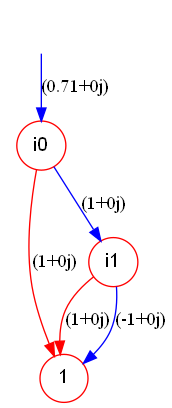

In [2]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tdd = tdd.as_tensor(U)

print(U_tdd.numpy())
U_tdd.show()

### TDD created with different index orders

#### 1. original order

[[[[ 0.5+0.j  0.5+0.j]
   [ 0.5+0.j  0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [ 0.5+0.j -0.5+0.j]]]


 [[[ 0.5+0.j  0.5+0.j]
   [-0.5+0.j -0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [-0.5+0.j  0.5+0.j]]]]


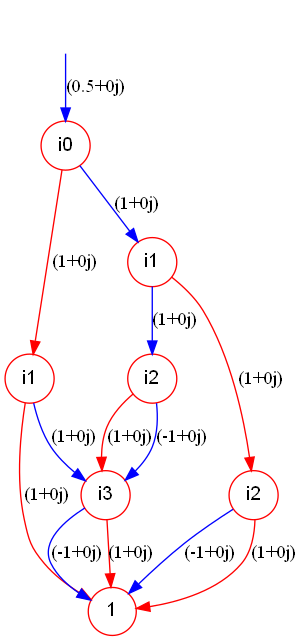

In [3]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd->acbd', U, U)
U_tdd = tdd.as_tensor((U_tensor,[],[0,1,2,3]))

print(U_tdd.numpy())
U_tdd.show()

#### 2. rearranged order

[[[[ 0.5+0.j  0.5+0.j]
   [ 0.5+0.j  0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [ 0.5+0.j -0.5+0.j]]]


 [[[ 0.5+0.j  0.5+0.j]
   [-0.5+0.j -0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [-0.5+0.j  0.5+0.j]]]]


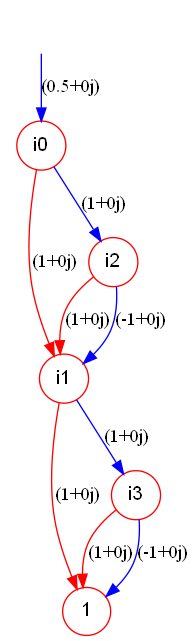

In [4]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd->acbd', U, U)
U_tdd = tdd.as_tensor((U_tensor,[],[0,2,1,3]))

print(U_tdd.numpy())
U_tdd.show()

### Parallel storage and calculation

#### storage without parallelization

[[[ 0.70710678+0.j  0.70710678+0.j]
  [ 0.70710678+0.j -0.70710678+0.j]]

 [[ 0.70710678+0.j  0.70710678+0.j]
  [-0.70710678+0.j  0.70710678+0.j]]]


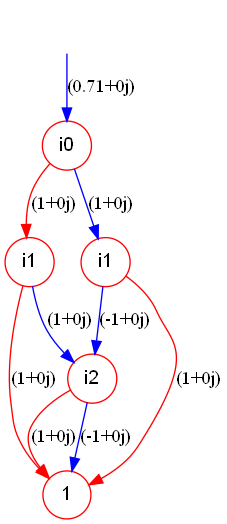

In [5]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[],[]))

print(U_tdd.numpy())
U_tdd.show()

#### storage with parallelization

[[[ 0.70710678+0.j  0.70710678+0.j]
  [ 0.70710678+0.j -0.70710678+0.j]]

 [[ 0.70710678+0.j  0.70710678+0.j]
  [-0.70710678+0.j  0.70710678+0.j]]]


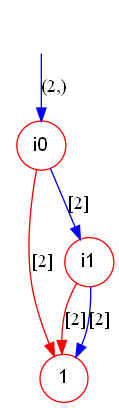

In [6]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2],[]))

print(U_tdd.numpy())
U_tdd.show()

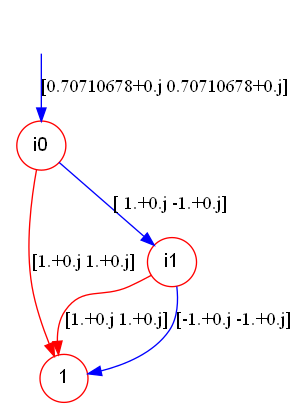

In [7]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2],[]))

U_tdd.show(full_output=True)

node weight demonstration

tensor([[[ 0.707106781186547,  0.000000000000000],
         [ 0.707106781186547,  0.000000000000000]],

        [[ 0.707106781186547,  0.000000000000000],
         [-0.707106781186547,  0.000000000000000]]], dtype=torch.float64)


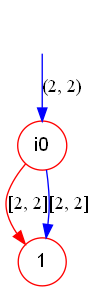

In [8]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2,2],[]))

print(U_tdd.weights)
U_tdd.show()

#### Demonstration of tdd's infimum type

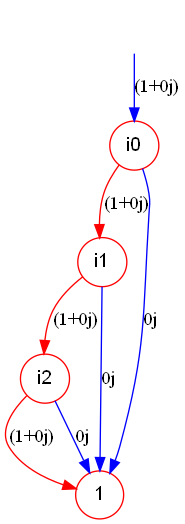

In [9]:
U = np.zeros((2,2,2))
U[0,0,0] = 1

U_tdd = tdd.as_tensor(U)
U_tdd.show()


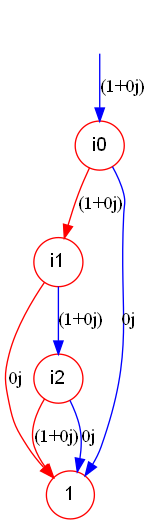

In [10]:
U = np.zeros((2,2,2))
U[0,1,0] = 1

U_tdd = tdd.as_tensor(U)
U_tdd.show()


the result of stack them together

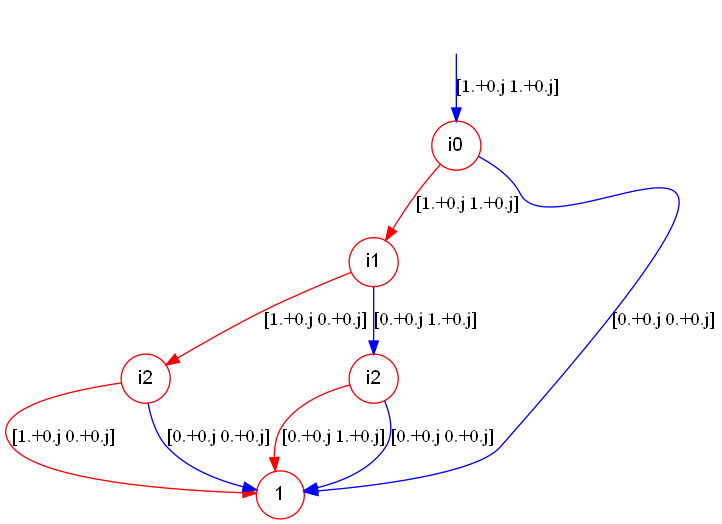

In [11]:
U1 = np.zeros((2,2,2))
U2 = np.zeros((2,2,2))
U1[0,0,0] = 1
U2[0,1,0] = 1

U_tdd = tdd.as_tensor((np.stack((U1,U2)),[2],[]))
U_tdd.show(full_output=True)

### indexing (slicing)

np result:
[[[[ 0.35355339  0.35355339]
   [ 0.35355339  0.35355339]]

  [[ 0.35355339 -0.35355339]
   [ 0.35355339 -0.35355339]]]


 [[[-0.35355339 -0.35355339]
   [-0.35355339 -0.35355339]]

  [[-0.35355339  0.35355339]
   [-0.35355339  0.35355339]]]]
tdd result:
[[[[ 0.35355339+0.j  0.35355339+0.j]
   [ 0.35355339+0.j  0.35355339+0.j]]

  [[ 0.35355339+0.j -0.35355339+0.j]
   [ 0.35355339+0.j -0.35355339+0.j]]]


 [[[-0.35355339+0.j -0.35355339+0.j]
   [-0.35355339+0.j -0.35355339+0.j]]

  [[-0.35355339+0.j  0.35355339+0.j]
   [-0.35355339+0.j  0.35355339+0.j]]]]


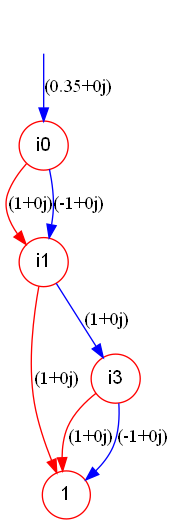

In [12]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd,ef->acebdf', U, U, U)

print('np result:')
print(U_tensor[:,0,:,1,...])

U_tdd = tdd.as_tensor((U_tensor,[],[0,3,1,4,2,5]))
U_tdd = U_tdd.index([(1,0),(3,1)])

print('tdd result:')
print(U_tdd.numpy())
U_tdd.show()

### tensordot

example1

np result:
[[1. 0.]
 [0. 1.]]
tdd result:
1
2
3
4
5
6
7
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


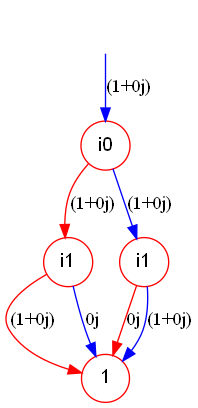

In [13]:
U=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

print('np result:')
print(np.tensordot(U, U, 1))

print('tdd result:')
U_tdd=tdd.as_tensor((U,[],[1,0]))
tdd_dot = tdd.tensordot(U_tdd,U_tdd,1)

print(tdd_dot.numpy())
tdd_dot.show()

example2

np result:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
tdd result:
1
2
3
4
5
6
7
8
9
10
11
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


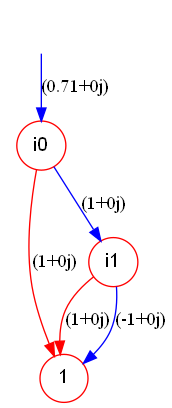

In [14]:
U=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

print('np result:')
print(U @ U @ U)

print('tdd result:')
U_prod = np.einsum('ab,cd,ef->acebdf',U,U,U)
U_tdd=tdd.as_tensor((U_prod,[],[0,1,3,4,2,5]))
tdd_dot = U_tdd.contract([[1,3],[2,4]])

print(tdd_dot.numpy())
tdd_dot.show()

## Comparing Performance

timing function

In [15]:
def timing(method, count=1):
    t1 = time.perf_counter()
    for i in range(count):
        method()
    t2 = time.perf_counter()
    print('total time: {}s, average time: {}s'.format(t2-t1, (t2-t1)/count))

def test_method():
    a = np.random.random((100,100))
#timing(test_method,100000)

In [16]:
import tdd_origin
from tdd import CUDAcpl
from tdd_origin import TDD, TN
import tqdm

### 1. N shot, m width, single-qubit gate multiplication

produce the same gates

In [17]:
#count = 1000 # <- recommended value for demonstration
count = 1
width = 5

rand_para_1 = torch.tensor(np.random.random((count, width)), device = CUDAcpl.device)
rand_para_2 = torch.tensor(np.random.random((count, width)), device = CUDAcpl.device)

gates_1 = CUDAcpl.ones(shape=(count,1,1))
gates_2 = CUDAcpl.ones(shape=(count,1,1))
for i in range(width):
    gates_1 = CUDAcpl.einsum('kab,kcd->kacbd', gates_1,
         CUDAcpl.quantum_basic.Rx(rand_para_1[:,i])).reshape((count,2**(i+1), 2**(i+1),2))
    gates_2 = CUDAcpl.einsum('kab,kcd->kacbd', gates_2,
         CUDAcpl.quantum_basic.Rx(rand_para_2[:,i])).reshape((count,2**(i+1), 2**(i+1),2))
gates_1 = gates_1.reshape((count,)+(2,)*width*2+(2,))
gates_2 = gates_2.reshape((count,)+(2,)*width*2+(2,))

gates_1_np = CUDAcpl.CUDAcpl2np(gates_1)
gates_2_np = CUDAcpl.CUDAcpl2np(gates_2)

print(gates_1.shape)
print(gates_1_np.shape)

torch.Size([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
(1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


#### PyTorch

In [19]:
indices1 =[]
indices2 =[]
for i in range(width):
    indices1.append(1+i*2+1)
    indices2.append(1+i*2)

result = CUDAcpl.tensordot(gates_1, gates_2, [indices1, indices2])
print(result)

tensor([[[[[[[[[[[[[ 0.369818739285412,  0.000000000000000],
                   [ 0.000000000000000, -0.260682668574589]],

                  [[ 0.000000000000000, -0.224785158888912],
                   [-0.158449502013745,  0.000000000000000]]],


                 [[[ 0.000000000000000, -0.278330506789530],
                   [-0.196193246983130,  0.000000000000000]],

                  [[-0.169176303270102,  0.000000000000000],
                   [ 0.000000000000000,  0.119251204742220]]]],



                [[[[ 0.000000000000000, -0.222699840543027],
                   [-0.156979575551167,  0.000000000000000]],

                  [[-0.135362580970689,  0.000000000000000],
                   [ 0.000000000000000,  0.095416146030799]]],


                 [[[-0.167606864919982,  0.000000000000000],
                   [ 0.000000000000000,  0.118144918516532]],

                  [[ 0.000000000000000,  0.101875680596148],
                   [ 0.071811461831198,  0.000000000000000]]]]]

[[[[[[[[[[[ 0.62577688+0.j          0.        -0.3878305j ]
          [ 0.        -0.24639315j -0.15270423+0.j        ]]

         [[ 0.        -0.25006463j -0.15497966+0.j        ]
          [-0.09846035+0.j          0.        +0.06102163j]]]


        [[[ 0.        -0.38010308j -0.23557209+0.j        ]
          [-0.14966164+0.j          0.        +0.09275406j]]

         [[-0.15189174+0.j          0.        +0.09413618j]
          [ 0.        +0.05980579j  0.03706514+0.j        ]]]]



       [[[[ 0.        -0.04916889j -0.03047283+0.j        ]
          [-0.01935974+0.j          0.        +0.01199836j]]

         [[-0.01964822+0.j          0.        +0.01217715j]
          [ 0.        +0.00773628j  0.00479463+0.j        ]]]


        [[[-0.02986567+0.j          0.        +0.0185095j ]
          [ 0.        +0.0117593j   0.00728792+0.j        ]]

         [[ 0.        +0.01193452j  0.00739652+0.j        ]
          [ 0.00469909+0.j          0.        -0.0029123j ]]]]]




      [[[[

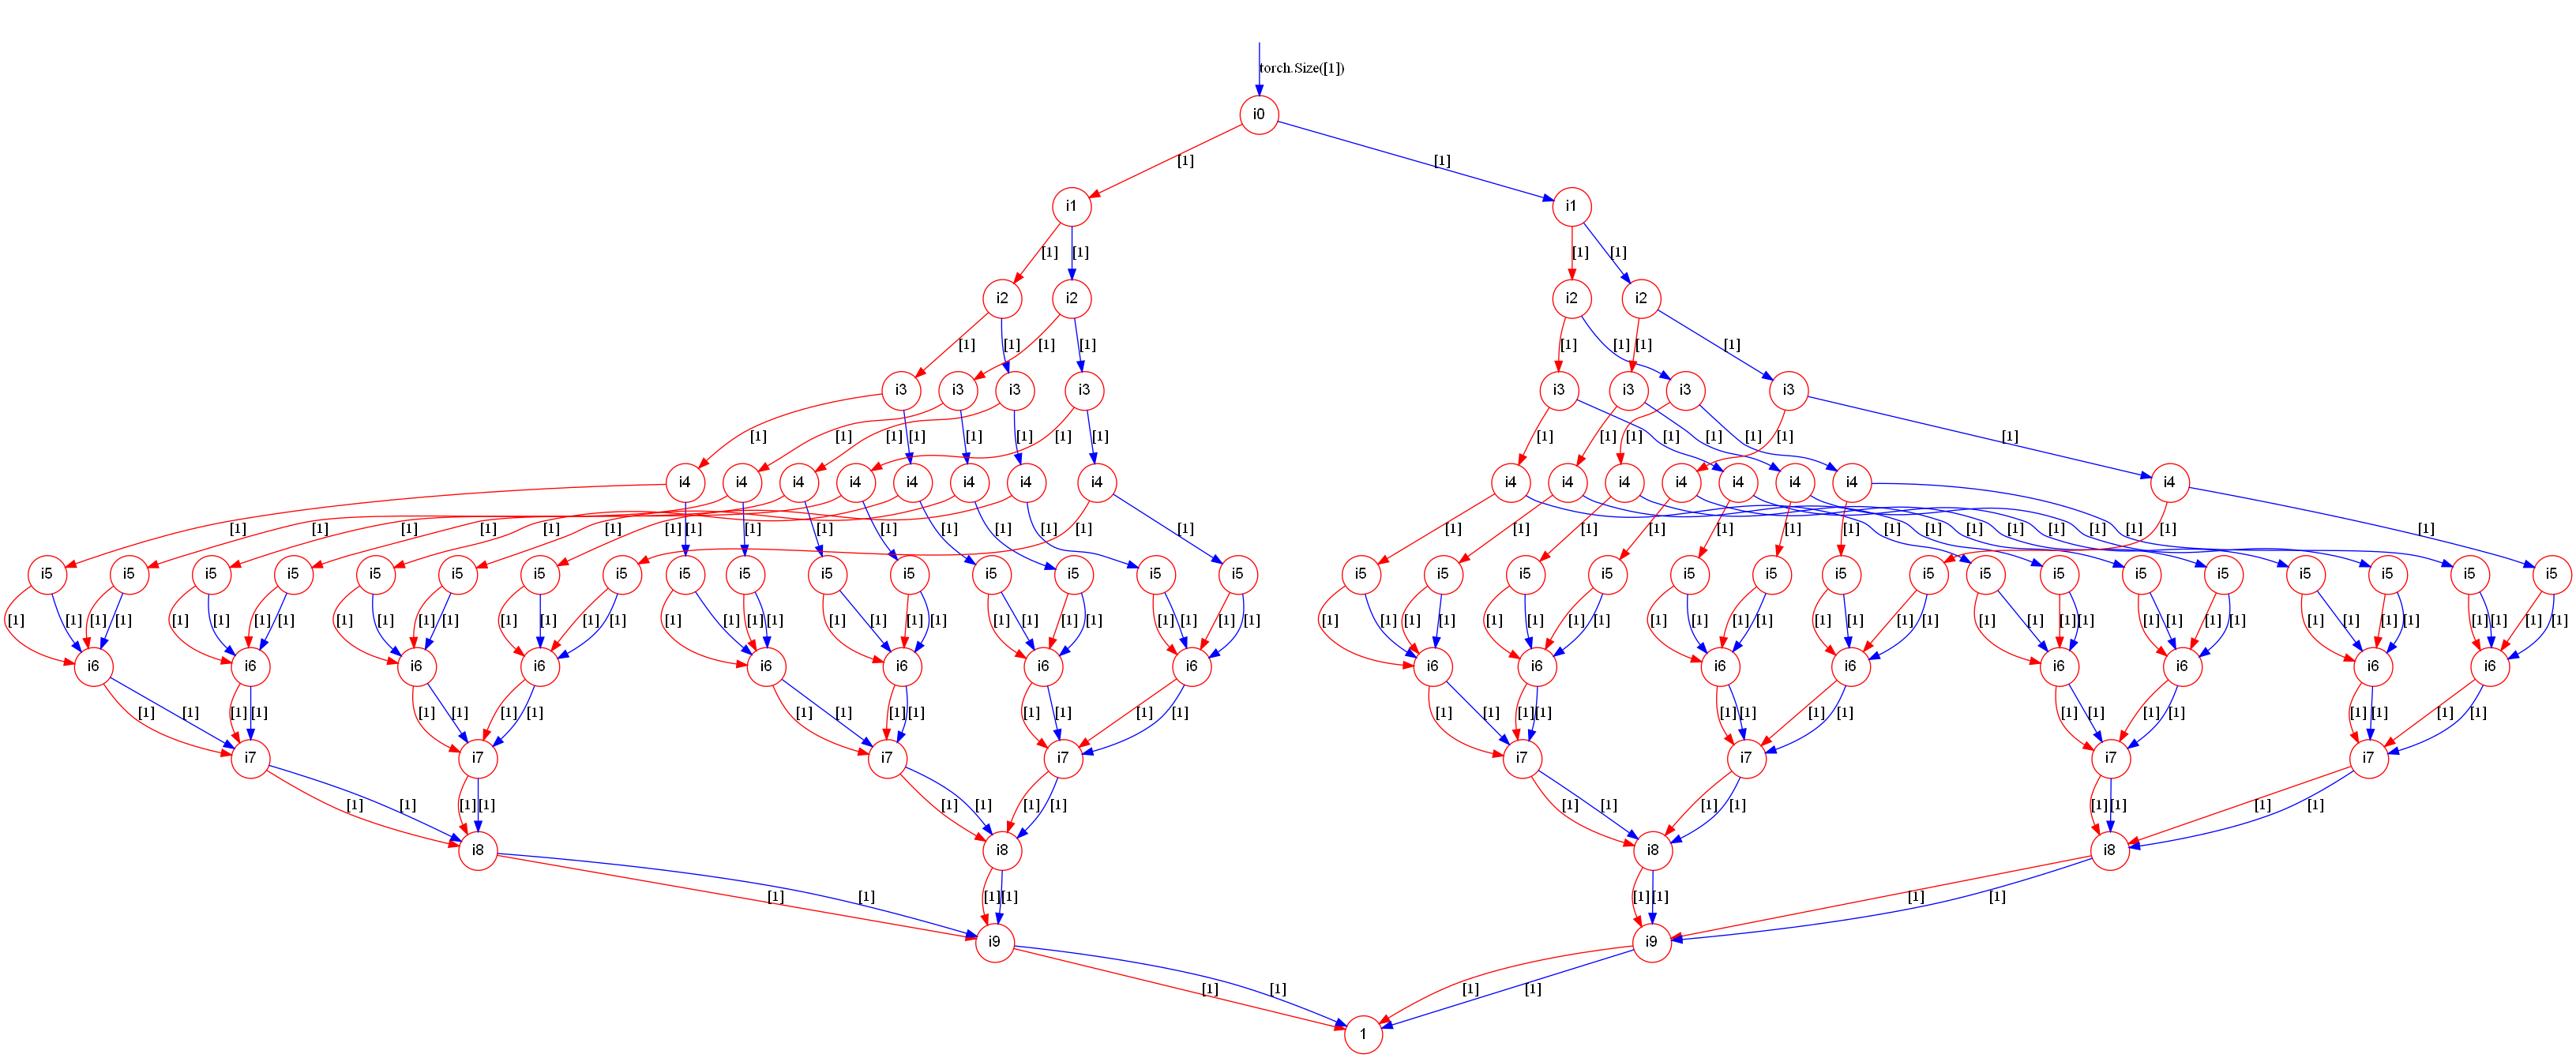

In [29]:
print(result_factorized)
result_factorized.show()

#### TDD (original)

In [20]:

def test_A():
    global result_origin
    #TDD.Ini_TDD([str(i)+'0' for i in range(width)]+[str(i)+'1' for i in range(width)]+[str(i)+'2' for i in range(width)])
    index_order = []
    for i in range(width):
        index_order.append(str(i)+'0')
        index_order.append(str(i)+'1')
        index_order.append(str(i)+'2')
    TDD.Ini_TDD(index_order)

    var1 = []
    var2 = []
    for i in range(width):
        var1.append(TN.Index(str(i)+'0'))
        var1.append(TN.Index(str(i)+'1'))
        var2.append(TN.Index(str(i)+'1'))
        var2.append(TN.Index(str(i)+'2'))

    #for i in tqdm.tqdm(range(count)):
    
    for i in range(count):
        TDD.call_count = 0

        ts1 = TN.Tensor(gates_1_np[i], var1)
        ts2 = TN.Tensor(gates_2_np[i], var2)

        tdd1 = ts1.tdd()
        tdd2 = ts2.tdd()
        tn = TN.TensorNetwork([ts1,ts2])
        result_origin = tn.cont()

timing(test_A, 1)

total time: 0.3445739999999944s, average time: 0.3445739999999944s


#### TDD (refactorized)

In [21]:
import tdd
import importlib
importlib.reload(tdd)

def test_B():
    global result_factorized
    indices1 =[]
    indices2 =[]

    for i in range(width):
        indices1.append(i*2+1)
        indices2.append(i*2)
    tdd1 = tdd.as_tensor((gates_1,[count],[]))
    tdd2 = tdd.as_tensor((gates_2,[count],[]))
    print('tdd1 size ', tdd1.get_size())
    result_factorized = tdd.tensordot(tdd1, tdd2, [indices1, indices2])

timing(test_B, 1)
print('yes')

tdd1 size  93


AttributeError: module 'tdd' has no attribute 'tensordot2'

##### Comparison of unique_key calculation

refactorized TDD

In [112]:
def A():
    a = result_factorized.node.unique_key
    return a

timing(A,100000)
print(A())

total time: 3.9503947999992306s, average time: 3.9503947999992307e-05s
(0, 1000000, 0, 1000000, 0, <tdd.node.Node object at 0x0000016E69CE1310>, <tdd.node.Node object at 0x0000016E69CE1D00>)


original TDD

In [113]:
x = result_origin.node.idx
weigs = result_origin.node.out_weight
succ_nodes = result_origin.node.successor
def B():
    temp_key=[0]
    for k in range(len(weigs)):
        temp_key.append(TDD.get_int_key(weigs[k]))
        temp_key.append(succ_nodes[k])
    temp_key=tuple(temp_key)
    return temp_key

timing(B,100000)
print(B())


total time: 1.0814821000003576s, average time: 1.0814821000003575e-05s
(0, (1000000, 0), <tdd_origin.TDD.Node object at 0x0000016E69D9BE20>, (1000000, 0), <tdd_origin.TDD.Node object at 0x0000016E69D9BDF0>)


## Other tests

In [119]:
a = torch.rand([1,1])
def PASS():
    b = torch.stack((a,a))

timing(PASS,200000)

total time: 1.222819999999956s, average time: 6.11409999999978e-06s


In [123]:
b = [1,2]

In [124]:
a+b

TypeError: unsupported operand type(s) for +: 'Tensor' and 'list'